In [1]:
import argparse, pydicom
import torch
import numpy as np

import tg43.dicom_helper as dhelp

from pathlib import Path
from typing import Any, Dict, Iterable, Tuple, List
from omegaconf import DictConfig, OmegaConf

In [2]:
def load_hyperparams(config_path: Path) -> Tuple[DictConfig, Dict]:
    """Load MCO-IPSA hyperparameters from YAML and resolve runtime types."""

    cfg = OmegaConf.load(config_path)
    cfg_dict = OmegaConf.to_container(cfg, resolve=True)  # type: ignore[arg-type]
    hyperparams = cfg_dict["hyperparams"]
    hyperparams["anisotropy_table"] = Path(hyperparams["anisotropy_table"])
    hyperparams["radial_table"] = Path(hyperparams["radial_table"])
    return cfg, hyperparams

def resolve_single(path_iterable: Iterable[Path], description: str) -> Path:
    """Return the first path from ``path_iterable`` or raise if empty."""

    candidates = sorted(path_iterable)
    if not candidates:
        raise FileNotFoundError(f"No files found for {description}.")
    return candidates[0]

def load_case_paths(root: Path, case_id: int) -> Dict[str, Path]:
    """Collect CT, RTDOSE, RTPLAN, and RTSTRUCT paths for a case."""

    case_dir = root / f"{case_id}"
    if not case_dir.exists():
        raise FileNotFoundError(f"Case directory not found: {case_dir}")

    return {
        "ct": resolve_single(case_dir.glob("CT*/*"), "CT series"),
        "dose": resolve_single(case_dir.glob("RTDOSE*/*/*.dcm"), "RTDOSE file"),
        "plan": resolve_single(case_dir.glob("RTPLAN*/*/*.dcm"), "RTPLAN file"),
        "struct": resolve_single(case_dir.glob("RTSTRUCT*/*/*.dcm"), "RTSTRUCT file"),
    }

In [3]:
cfg, hyperparams = load_hyperparams(Path("config.yaml"))
cfg, hyperparams

({'hyperparams': {'anisotropy_table': './ESTRO/nucletron_mhdr-v2_F.xlsx', 'radial_table': './ESTRO/nucletron_mhdr-v2_gL.xlsx'}, 'run': {'data-root': '/mnt/d/PRV/GYN_Geneva_wo_Needles', 'case': 'Case6'}},
 {'anisotropy_table': PosixPath('ESTRO/nucletron_mhdr-v2_F.xlsx'),
  'radial_table': PosixPath('ESTRO/nucletron_mhdr-v2_gL.xlsx')})

In [4]:
data_root = Path(cfg['run']['data-root'])
case_id = Path(cfg['run']['case'])
print(f"Data root: {data_root}")
print(f"Case ID: {case_id}")
paths = load_case_paths(data_root, case_id)
paths

Data root: /mnt/d/PRV/GYN_Geneva_wo_Needles
Case ID: Case6


{'ct': PosixPath('/mnt/d/PRV/GYN_Geneva_wo_Needles/Case6/CT_0_20240112/series_3_1.3.6.1.4.1.2452.6.1088874395.1296847118.3536313259.1264601617'),
 'dose': PosixPath('/mnt/d/PRV/GYN_Geneva_wo_Needles/Case6/RTDOSE_0_20240112/series_1_1.3.6.1.4.1.2452.6.2542691449.1298947939.3638676387.3704138358/ima_unknown_uid_1.3.6.1.4.1.2452.6.1444471091.1123319702.4073412502.1826252067.dcm'),
 'plan': PosixPath('/mnt/d/PRV/GYN_Geneva_wo_Needles/Case6/RTPLAN_0_20240112/series_1_1.3.6.1.4.1.2452.6.1356188019.1134003628.1522809736.1180775174/ima_empty_uid_1.3.6.1.4.1.2452.6.3162210145.1093853173.1113596587.2422958571.dcm'),
 'struct': PosixPath('/mnt/d/PRV/GYN_Geneva_wo_Needles/Case6/RTSTRUCT_0_20240112/series_1_1.3.6.1.4.1.2452.6.3775943779.1152257382.1983088276.1409971453/ima_empty_uid_1.3.6.1.4.1.2452.6.3039571248.1233624635.2885846168.1640366842.dcm')}

In [5]:
ct_image, ct_array, ct_metadata = dhelp.load_ct_volume(paths['ct'])
ct_array.shape

(160, 512, 512)

In [64]:
import importlib
import src.dinov3 as dinov3
importlib.reload(dinov3)

dinov3_fe = dinov3.DINOV3FeatureExtractor()

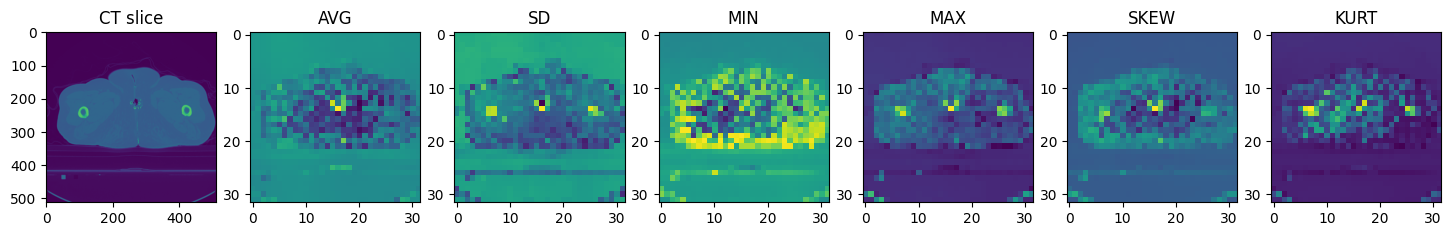

In [74]:
import matplotlib.pyplot as plt

idx_slice = 30

features = dinov3_fe.extract_features(torch.tensor(ct_array[idx_slice]))
stats, names = dinov3_fe.feature_stats(features)

num_feat = stats.shape[-1]
fig, axes = plt.subplots(1, num_feat+1, figsize=(3*num_feat, 3))

axes[0].set_title("CT slice")
axes[0].imshow(ct_array[idx_slice])
for feat_dx in range(num_feat):
    axes[feat_dx+1].set_title(names[feat_dx])
    axes[feat_dx+1].imshow(stats[:, :, feat_dx].cpu().numpy())